In [2]:
import matplotlib
matplotlib.use('WebAgg')

# Date and time
from dateutil.relativedelta import relativedelta
import datetime

# Computational modules
import zarr
import dask.delayed as delayed
from dask import compute
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs

# Plotting
from matplotlib import pyplot as plt
from matplotlib import cm
np.seterr(divide='ignore', invalid='ignore')
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.seterr(divide='ignore', invalid='ignore')
get_ipython().run_line_magic("matplotlib", "inline")
plt.rcParams["figure.figsize"] = 12, 6
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")


# Maps   
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray
import geopandas as gpd
from shapely.geometry import box, mapping

# Additional modules required
import sys
!{sys.executable} -m pip install --user cmip6_preprocessing
!{sys.executable} -m pip install --user rioxarray
!{sys.executable} -m pip install --user salem
!{sys.executable} -m pip install --user nc-time-axis

# Local files and utility functions
sys.path.append("./subroutines/")
import pices
import salem

#### Light calculations
Here we use pysolar python modules to perform the light calculations

In [3]:
grid_labels = ["gr"]

member_ids = [
    "r1i1p1f1"
]
member_ids = ["r1i1p1f1"]

experiment_ids = ["ssp585"]  #1pctCO2 'abrupt-4xCO2',
institution_ids = ["NOAA-GFDL"]
source_ids = ["GFDL-ESM4"]
variable_ids = ["sithick", "siconc", "sisnthick", "sisnconc"]
table_ids = ["SImon", "SImon", "SImon", "SImon"]
# variable_ids = ["sithick"]

#### Query data
The dataset returned from the query need to be checked for time dimension. If the time array 
uses a relative date (0001 instead of 20001) then the values need to be added 2000 prior to converting to 
datetime64 format.

https://unidata.github.io/cftime/api.html
http://xarray.pydata.org/en/stable/time-series.html

In [4]:
def plot_timeseries(ds_dict, ds_area):

    plt.figure(figsize=(12, 8))

    for name, ds in ds_dict.items():

        #  total_area = ds_area.areacella.sum(dim=['lat', 'lon'])
        #   print(ds_area.areacella)
        if name == "sithick":
            ta_timeseries = ds.sithick.mean(
                dim=["lat", "lon"]
            )  # * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
        if name == "sisnthick":
            ta_timeseries = ds.sisnthick.mean(
                dim=["lat", "lon"]
            )  # * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
        if name == "siconc":
            ta_timeseries = ds.siconc.mean(
                dim=["lat", "lon"]
            )  # * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
        if name == "sisnconc":
            ta_timeseries = ds.sisnconc.mean(
                dim=["lat", "lon"]
            )  # * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
        if name == "tas":
            ta_timeseries = ds.tas.mean(
                dim=["lat", "lon"]
            )  # * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area

        plt.ylabel(r"global-mean {}".format(name))
        ta_timeseries.plot()
        ta_timeseries.rolling(time=12).mean().plot(color="r")

        plt.xlabel("time")
        #   plt.xlim([1850,2100]);
        plt.show()


#  plot_map(ds)
# plt.savefig('../figures/ssp585_global_warming.png',dpi=100,bbox_inches='tight')

In [5]:
def plot_map(ds):
    plt.figure(figsize=(14, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ds.sithick[0].plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), x="xc", y="yc", add_colorbar=False
    )
    ax.coastlines()
    ax.set_ylim([0, 90])
    plt.show()

In [6]:
def perform_query(query_string):
    df_sub = df.query(query_string)
    mapper = fs.get_mapper(df_sub.zstore.values[-1])
    ds = xr.open_zarr(mapper, consolidated=True)
    time_object = ds["time"].values[0]

    # Convert if necesssary
    if time_object.year == 1:

        times = ds["time"].values
        times_plus_2000 = []
        for t in times:
            times_plus_2000.append(
                cftime.DatetimeNoLeap(t.year + 2000, t.month, t.day, t.hour)
            )
        ds["time"].values = times_plus_2000
        ds = xr.decode_cf(ds)
    print(
        "=> Dates extracted range from {} to {}\n".format(
            ds["time"].values[0], ds["time"].values[-1]
        )
    )
    return ds

In [7]:
def calculate_light(lon, lat, when, snow_thickness, ice_thickness):
    altitude_deg = solar.get_altitude(lat, lon, when)
    surface_light = radiation.get_radiation_direct(when, altitude_deg)

    return calculate_light_under_sea_ice(snow_thickness, ice_thickness, surface_light)

In [8]:
def calculateArea(lat0, lat1, lon0, lon1, areaIce):

    earthRadius = 6371000
    rad = np.pi / 180.0

    """    -180 <= lon0 < lon1 <= 180
            -90 <= lat0 < lat1 <= 90
            areaIce is in percent
    """

    area = (
        earthRadius ** 2
        * (np.sin(lat1 * rad) - np.sin(lat0 * rad))
        * (lon1 - lon0)
        * rad
    )
    return area * (areaIce)

In [9]:
def calculate_light_under_sea_ice(
    snow_thickness, ice_thickness, surface_light, debug=False
):
    # Now calculate the amount of light below the sea ice and snow (Perovich 1996,
    # but see  Jin 2006 Annals of Glaciology)
    attenuationSnow = 20  # unit : m-1
    attenuationIceTop10cm = 5
    attenuationIceBelowSurface = 1
    missing_value = 1e20

    if 0 < snow_thickness < missing_value:
        albedo = 0.9
        #   if debug is True:
        #       print("Albedo for snow and ice covered water: {}".format(albedo))
        surface_light = (1.0 - albedo) * surface_light
    if snow_thickness == 0 and 0 < ice_thickness < missing_value:
        albedo = 0.5
        #    if debug is True:
        #        print("Albedo for ice covered water: {}".format(albedo))
        surface_light = (1.0 - albedo) * surface_light
    if (snow_thickness == 0 and ice_thickness == 0) or (
        snow_thickness == missing_value and ice_thickness == missing_value
    ):
        albedo = 0.06
        #   if debug is True:
        #       print("Albedo for open water: {}".format(albedo))
        surface_light = (1.0 - albedo) * surface_light

    Eb = surface_light
    # if debug is True:
    #     print("\nSurface light {}".format(Eb))
    if 0 < snow_thickness < missing_value:
        Eb = surface_light * np.exp(attenuationSnow * (-snow_thickness))
    #   if debug is True:
    #       print("Eb with snow (%s m) : {}".format(snow_thickness, Eb))

    if 0.1 <= ice_thickness < missing_value:

        Eb = Eb * np.exp(attenuationIceTop10cm * (-0.1))
        #     if debug is True:
        #         print("Eb with ice top (%s m) : {}".format(ice_thickness, Eb))
        Eb = Eb * np.exp(attenuationIceBelowSurface * (-(ice_thickness - 0.1)))
    #     if debug is True:
    #         print("Eb with ice below top (%s m) : {}".format(ice_thickness - 0.1, Eb))
    else:
        Eb = Eb * np.exp(attenuationIceTop10cm * (-ice_thickness))
    #    if debug is True:
    #        print("Eb with ice top (%s m) : {}".format(ice_thickness, Eb))

    # print "Eb", Eb, "snow", snowthickness, "ice", icethickness, "albedo", albedo

    # if snowthickness==missing_value or icethickness==missing_value or albedo==missing_value:
    #     return missing_value
    return Eb

### Setup system
#### Setup ssh tunnel
gcloud compute ssh  --zone="us-west1-b" --ssh-flag="-D" --ssh-flag="1080" --ssh-flag="-N" --ssh-flag="-n" jupyter
 
#### Setup Google chrome for proxy
 /Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome --proxy-server="socks5://localhost:1080" \
  --host-resolver-rules="MAP * 0.0.0.0 , EXCLUDE localhost" \
  --user-data-dir=/tmp/
  
#### Status
http://jupyter:8787/status
  
#### Useful links
https://climate-cms.org/2019/11/12/Calendars-and-monthly-data.html
http://xarray.pydata.org/en/stable/examples/monthly-means.html
https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
http://meteo.unican.es/work/xarray_seminar/xArray_seminar.html
 
#### Setting up SSH port forwarding on google gloud
https://haroldsoh.com/2016/04/28/set-up-anaconda-ipython-tensorflow-julia-on-a-google-compute-engine-vm/
 
#### Problems memory leak
https://github.com/dask/distributed/issues/2068


In [10]:
def run_tasks_for_dataset(dset_dict):

    from dask.distributed import Client, progress
    from numpy import vectorize

    # https://github.com/dask/dask-labextension
    client = Client(
        "tcp://127.0.0.1:39439"
    )  # , processes=False, threads_per_worker=2, n_workers=4)
    DD_COUNT = 12
    min_latitude = 40
    final_year = 2050

    calculate_light_under_sea_ice_vector = np.vectorize(calculate_light_under_sea_ice)
    calculate_light_vector = np.vectorize(calculate_light)

    with client:

        snow_thickness = dset_dict["sisnthick"].sisnthick
        snow_thickness = snow_thickness.where(
            snow_thickness.lat > min_latitude, drop=True
        )
        ice_thickness = dset_dict["sithick"].sithick
        ice_thickness = ice_thickness.where(
            snow_thickness.lat > min_latitude, drop=True
        )
        times = snow_thickness["time"].values

        when = []
        for ind, dd in enumerate(times):
            date_current = datetime.datetime(
                dd.year, dd.month, dd.day, tzinfo=datetime.timezone.utc
            )
            when.append(date_current)

        for end_index,d in enumerate(when):
            if d.year==final_year:
                break
        print('End index {} equals date {}'.format(end_index,when[end_index]))
          
            
        z = np.zeros(
            (len(when[0:end_index]), len(snow_thickness.lat.values), len(snow_thickness.lon.values))
        )
        lons = snow_thickness.lon.values
        lats = snow_thickness.lat.where(
            snow_thickness.lat > min_latitude, drop=True
        ).values

        n = len(snow_thickness.lon.values)
        m = len(snow_thickness.lat.values)

        start_time_index = 0
        end_time_index = DD_COUNT
        lonss, latss = np.meshgrid(lons, lats)
              
        for start_time_index in range(0, end_index, DD_COUNT):

            ict = ice_thickness.values[start_time_index:end_time_index, :, :]
            snt = snow_thickness.values[start_time_index:end_time_index, :, :]

            zr = [
                delayed(calculate_light_vector)(
                    lonss, latss, when[start_time_index + t], snt[t, :, :], ict[t, :, :]
                )
                for t in range(DD_COUNT)
            ]

            final = dask.compute(zr)
            zr = np.fliplr(np.array(final).reshape((DD_COUNT, m, n)))
            z[start_time_index:end_time_index, :, :] = zr

            print(
                "Progress indexes: start {}={} end {}={}".format(
                    start_time_index,
                    when[start_time_index],
                    end_time_index,
                    when[end_time_index],
                )
            )
            end_time_index += DD_COUNT

        #  plt.figure(figsize=(12, 12))
        #  plt.imshow(z[start_time_index, :, :])
        #  plt.colorbar(shrink=0.3)
        #  plt.title('Date {}'.format(when[start_time_index]))

    print("Writing results to file. Shape of data {}".format(np.shape(z)))

    ds = xr.DataArray(
        z, dims=["time","lat","lon"], coords={"lon": lons, "lat": lats, "time": times[0:end_index]}
    )
    ds.to_netcdf("test.nc")

Running historical query on data: 
 ==> source_id=='GFDL-ESM4'and table_id=='SImon' and member_id=='r1i1p1f1' and grid_label=='gr' and experiment_id=='esm-hist' and variable_id=='sithick'

=> Dates extracted range from 1850-01-16 12:00:00 to 2014-12-16 12:00:00

Running projections query on data: 
 ==> source_id=='GFDL-ESM4'and table_id=='SImon' and member_id=='r1i1p1f1' and grid_label=='gr' and experiment_id=='ssp585' and variable_id=='sithick'

=> Dates extracted range from 2015-01-16 12:00:00 to 2100-12-16 12:00:00

Running historical query on data: 
 ==> source_id=='GFDL-ESM4'and table_id=='SImon' and member_id=='r1i1p1f1' and grid_label=='gr' and experiment_id=='esm-hist' and variable_id=='siconc'

=> Dates extracted range from 1850-01-16 12:00:00 to 2014-12-16 12:00:00

Running projections query on data: 
 ==> source_id=='GFDL-ESM4'and table_id=='SImon' and member_id=='r1i1p1f1' and grid_label=='gr' and experiment_id=='ssp585' and variable_id=='siconc'

=> Dates extracted range f

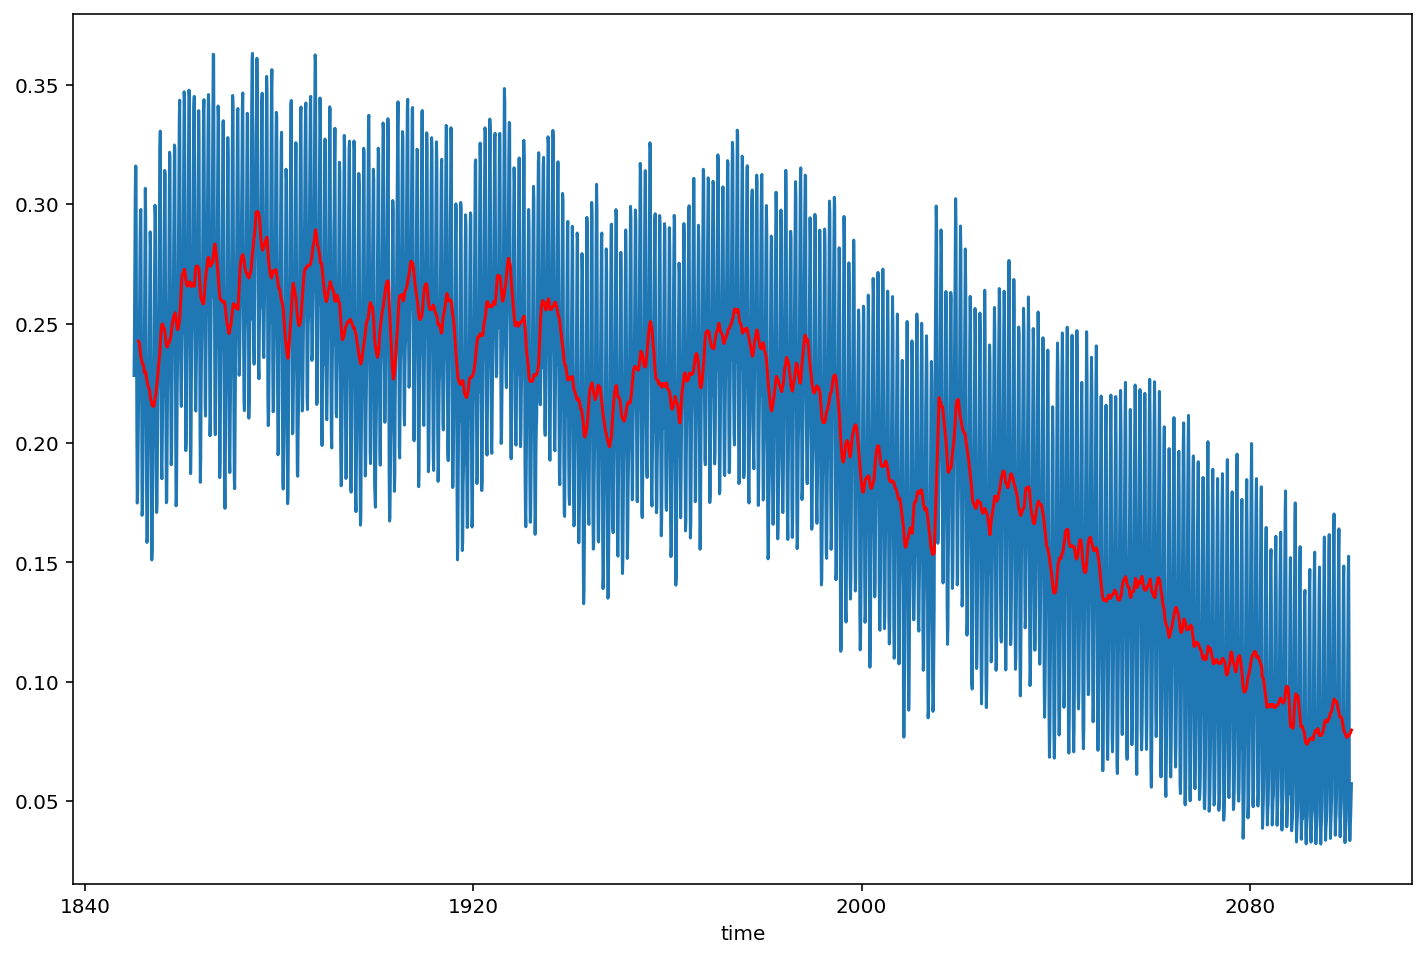

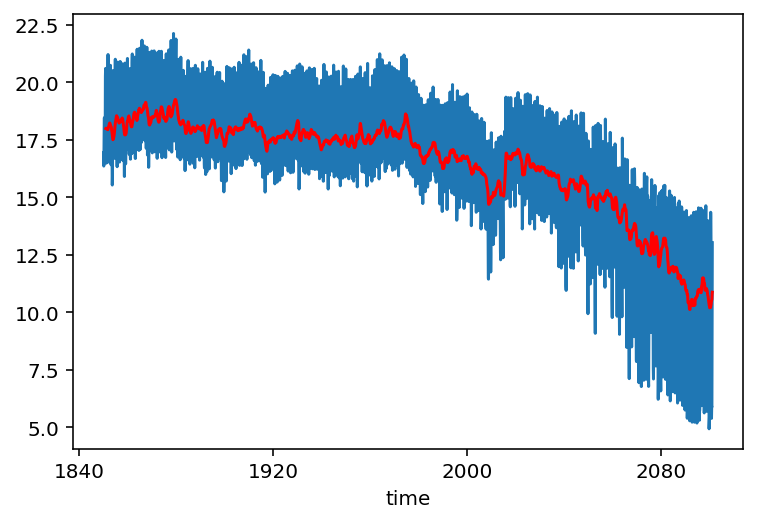

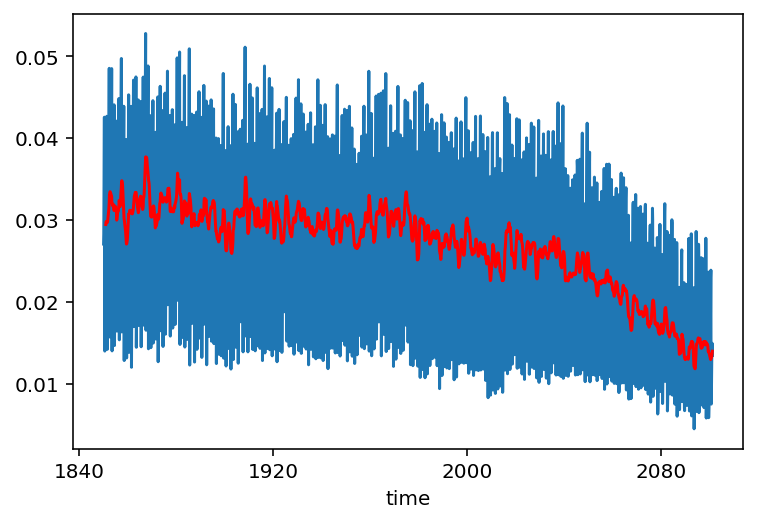

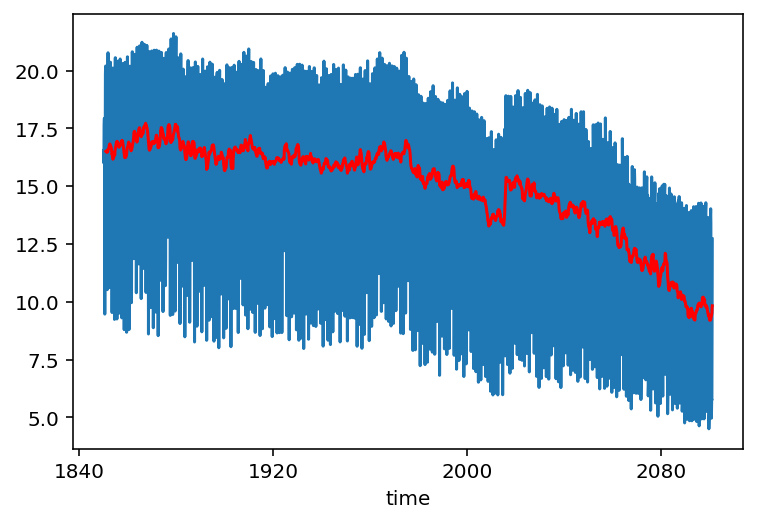

In [11]:
# Dicitionary to hold the queried variables
dset_dict = {}
first = True
for experiment_id in experiment_ids:
    for grid_label in grid_labels:
        for source_id in source_ids:
            for member_id in member_ids:
                for variable_id, table_id in zip(variable_ids, table_ids):

                    # Historical

                    query_string = "source_id=='{}'and table_id=='{}' and member_id=='{}' and grid_label=='{}' and experiment_id=='esm-hist' and variable_id=='{}'".format(
                        source_id, table_id, member_id, grid_label, variable_id
                    )

                    print(
                        "Running historical query on data: \n ==> {}\n".format(
                            query_string
                        )
                    )
                    ds_hist = perform_query(query_string)

                    # Future projection depending on choice in experiment_id
                    query_string = "source_id=='{}'and table_id=='{}' and member_id=='{}' and grid_label=='{}' and experiment_id=='{}' and variable_id=='{}'".format(
                        source_id,
                        table_id,
                        member_id,
                        grid_label,
                        experiment_id,
                        variable_id,
                    )
                    print(
                        "Running projections query on data: \n ==> {}\n".format(
                            query_string
                        )
                    )
                    ds_proj = perform_query(query_string)

                    if first:
                        df_area = df.query(
                            "variable_id == 'areacella' and source_id =='{}'".format(
                                source_id
                            )
                        )
                        ds_area = xr.open_zarr(
                            fs.get_mapper(df_area.zstore.values[0]), consolidated=True
                        )
                        first = False

                    # Concatentate the historical and projections datasets
                    ds = xr.concat([ds_hist, ds_proj], dim="time")

                    # Remove the duplicate overlapping times (e.g. 2001-2014)
                    _, index = np.unique(ds["time"], return_index=True)
                    ds = ds.isel(time=index)

                    # Save the dataset for variable_id in the dictionary
                    dset_dict[variable_id] = ds


run_tasks_for_dataset(dset_dict)

# Plot the global average timeseries for each variable
plot_timeseries(dset_dict, ds_area)